In [18]:
import pickle
import os
import scipy.stats
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
from visualisation_utils import VisualisationUtils

utils = VisualisationUtils()
sns.set_context("talk")
sns.set_style("white")

### Section 3.2: Control setup

In [19]:
def control_setup():
    metavalidation_results = defaultdict(lambda: dict())
    for modeln, model in utils.model_setups:
        for dataset_name in utils.control_setup_ds_names:
            accuracy1, accuracy2 = [], []
            for target, freeze in utils.control_setups: 
                filename = f"../results/layer_swapping/{dataset_name}/{model}_seed=1_freeze={freeze}_epoch=50.pt.pickle"
                average_over_num_layers_affected = utils.get_heatmap_and_averages(
                    filename, retraining=False)[1]
   
                # Now get the two/one top scoring layers in terms of memorisation error
                layers = np.argsort(average_over_num_layers_affected)[-2:]
                for l in layers:
                    accuracy2.append(l in target)
                accuracy1.append(layers[-1] in target)
    
            metavalidation_results[modeln, dataset_name]["accuracy@1"] = np.mean(accuracy1)
            metavalidation_results[modeln, dataset_name]["accuracy@2"] = np.mean(accuracy2)
    pickle.dump(dict(metavalidation_results), open("pickled_results/swapping_control.pickle", 'wb'))


control_setup()

### Section 4: Results

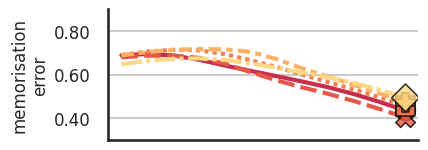

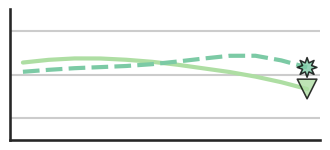

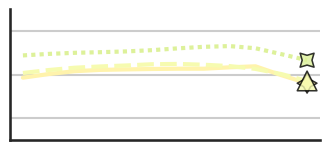

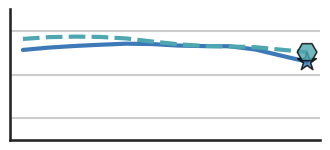

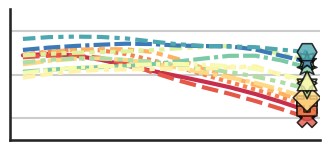

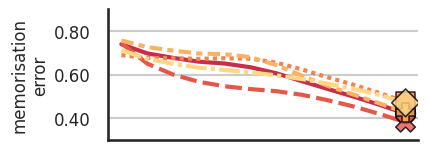

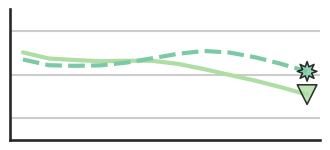

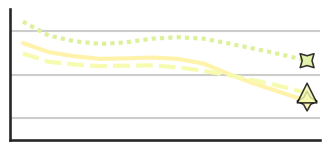

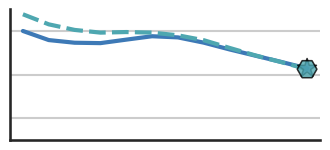

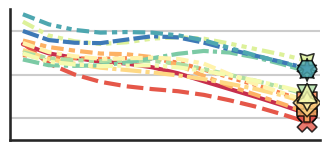

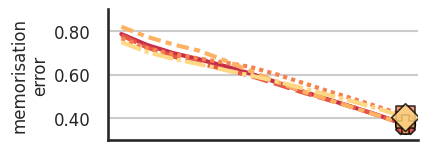

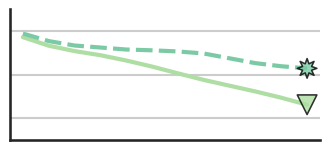

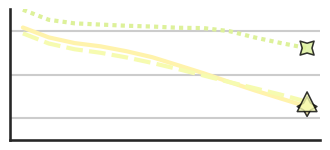

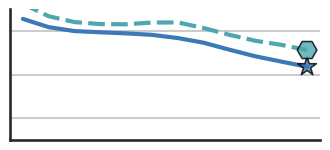

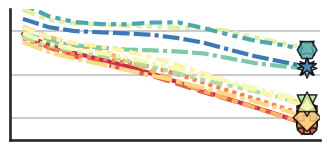

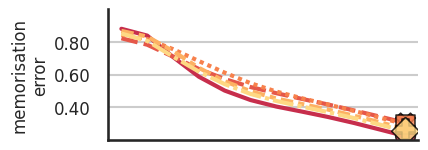

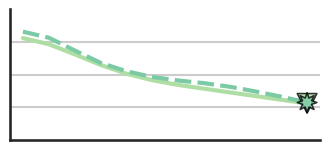

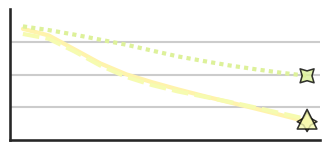

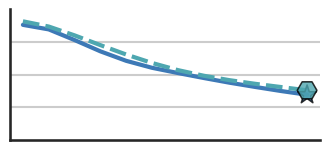

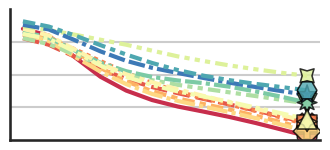

Accuracy for clean examples: 0.997 +/- 0.012


In [20]:
def process_swapping(data_setups, seeds=[1, 2, 3], visualise_all=True, visualise_summary=True):
    all_clean_accs = []
    results = defaultdict(lambda: dict())
    results_top_row = defaultdict(lambda: dict())
    mcog = defaultdict(lambda: dict())

    for modeln, model in utils.model_setups:
        for setup, ds_names in data_setups:
            allx, ally, allh = [], [], []
            for dataset in ds_names:
                heatmaps = []
                for seed in seeds:
                    filename = f"../results/layer_swapping/{dataset}/{model}_seed={seed}_freeze=embeddings_epoch=50.pt.pickle"
                    heatmap, _, clean_accs = \
                        utils.get_heatmap_and_averages(filename, retraining=False)
                    heatmaps.append(heatmap)
                    all_clean_accs.extend(clean_accs)
                heatmap_over_seeds = np.array(heatmaps).mean(axis=0)

                # Store individual heatmaps for model - dataset combinations
                if visualise_all:
                    utils.save_heatmap(heatmap_over_seeds, f"layer_swapping/{model}_{dataset}.pdf")
                flattened_heatmap = heatmap_over_seeds.mean(axis=0)
                results[model][dataset.replace("v2", '')] = flattened_heatmap
                results_top_row[model][dataset] = heatmap_over_seeds[0].tolist()
       
                mcog[model][dataset.replace("v2", '')] = \
                    np.sum([x_*y_ for x_, y_ in zip(range(0, 12), flattened_heatmap)])/np.sum(flattened_heatmap)
                allx.extend(list(range(12)))
                ally.extend(flattened_heatmap)
                allh.extend([dataset]*12)

            # Visualise the flattened heatmaps per group of datasets (setup)
            if visualise_summary:
                if "Pythia" in modeln:
                    utils.visualise_flattened_heatmap(allx, ally, allh, setup, modeln, retraining=False,
                                                      ymin=0.2, ymax=1)
                else:
                    utils.visualise_flattened_heatmap(allx, ally, allh, setup, modeln, retraining=False)

    # Summarise the results of swapping only one layer at a time in a swarmplot
    if visualise_all:
        utils.visualise_single_row(results_top_row, retraining=False)

    print(f"Accuracy for clean examples: {np.mean(all_clean_accs):.3f} +/- {np.std(all_clean_accs):.3f}")
    return dict(results), dict(mcog)


results, mcog = process_swapping(utils.data_setups, visualise_all=False, visualise_summary=True)
pickle.dump((results, mcog), open("pickled_results/swapping_main.pickle", 'wb'))

### Appendix C: Binarisation of tasks

Accuracy for clean examples: 0.998 +/- 0.008
Accuracy for clean examples: 0.992 +/- 0.060
Correlation: 0.84 (p=0.00), mean diff: -0.05, mean abs diff: 0.16


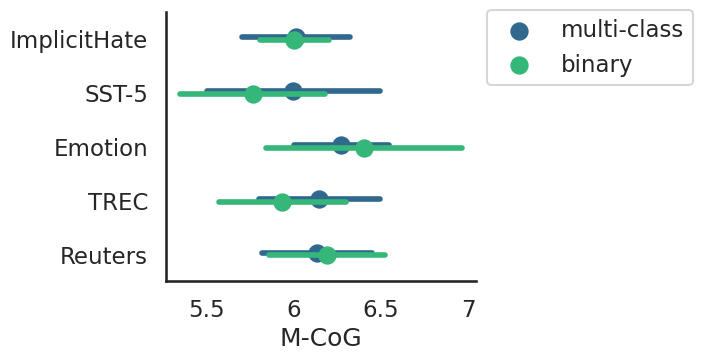

In [21]:
data_setups = [("bin", ["implicithate", "sst5", "emotion", "trec", "reuters"])]
_, mcog_multiclass = process_swapping(data_setups, seeds=[1], visualise_all=False, visualise_summary=False)

data_setups = [("binv2", ["implicithatev2", "sst5v2", "emotionv2", "trecv2", "reutersv2"])]
_, mcog_binary = process_swapping(data_setups, seeds=[1], visualise_all=False, visualise_summary=False)

h1, h2, d1, d2, x, y = [], [], [], [], [], []
for m in mcog_multiclass:
    x.extend(mcog_multiclass[m].values())
    y.extend(mcog_binary[m].values())
    d1.extend([utils.capitalise(name) for name in mcog_multiclass[m]])
    d2.extend([utils.capitalise(name) for name in mcog_binary[m]])
    h1.extend(["multi-class"]*5)
    h2.extend(["binary"]*5)

r, p = scipy.stats.spearmanr(x, y)
mean_diff = np.mean([y_ - x_ for x_, y_ in zip(x, y)])
mean_abs_diff = np.mean([abs(y_ - x_) for x_, y_ in zip(x, y)])
print(f"Correlation: {r:.2f} (p={p:.2f}), mean diff: {mean_diff:.2f}, mean abs diff: {mean_abs_diff:.2f}")

plt.figure(figsize=(4, 3.5))
ax = sns.pointplot(x=x + y, y=d1 + d2, hue=h1 + h2, palette='viridis', errorbar='sd',
                   orient='h', join=False, dodge=True)
plt.xlabel("M-CoG")
sns.despine()
plt.legend(bbox_to_anchor=(1, 1.05))
# + 1, since layer 1 is at index 0
ax.set_xticks([4.5, 5, 5.5, 6], [5.5, 6, 6.5, 7])
plt.savefig("layer_swapping/binarised_mcog.pdf", bbox_inches="tight")
plt.show()

### Appendix D: OPT 1.3B

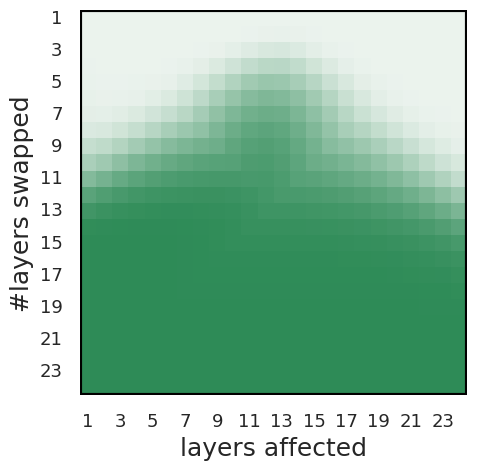

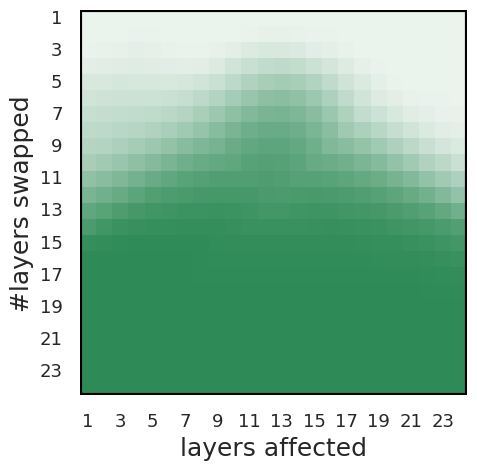

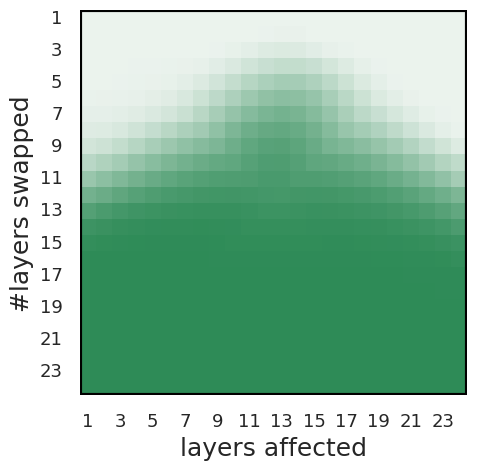

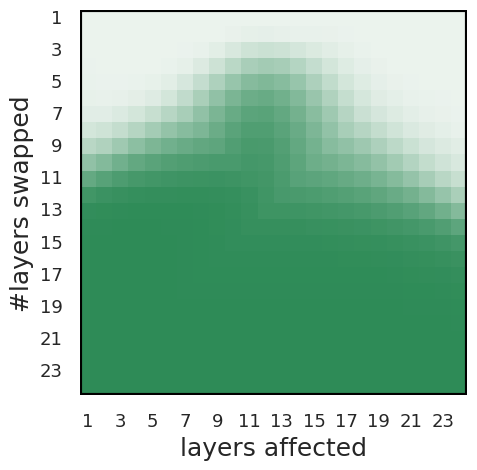

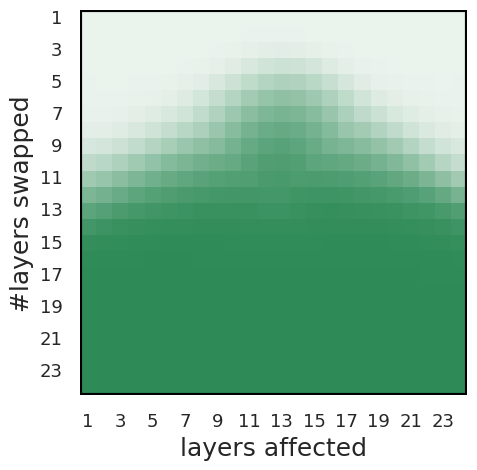

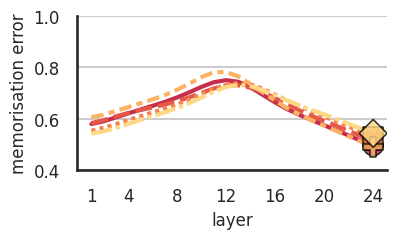

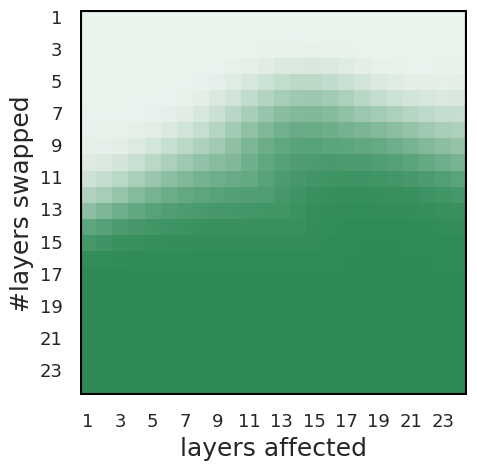

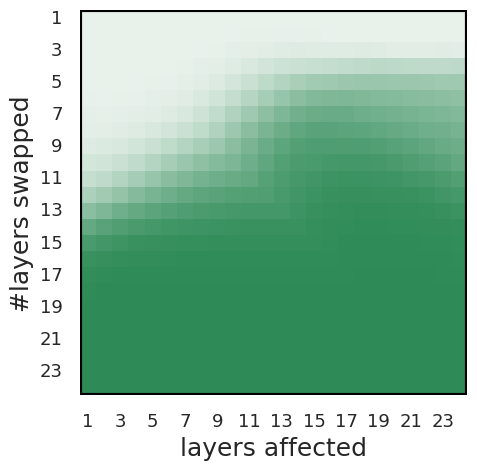

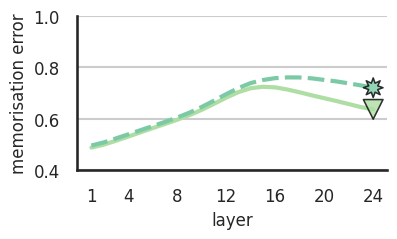

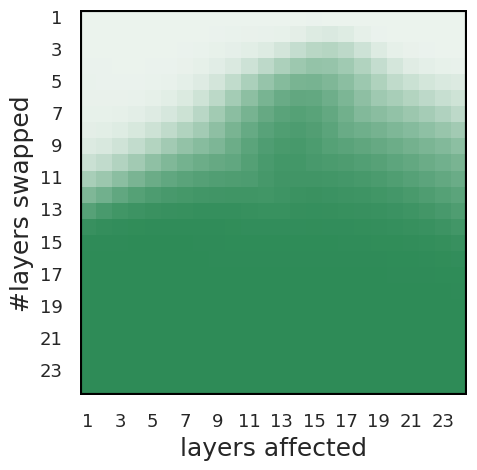

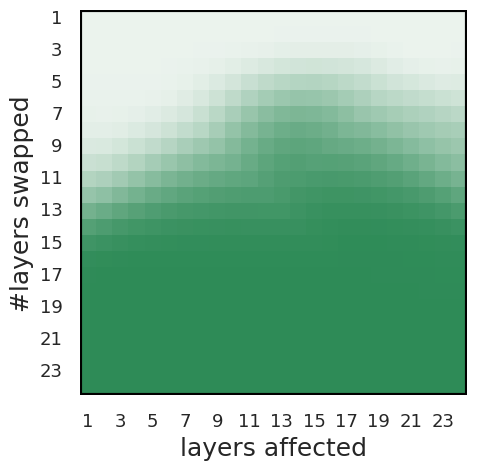

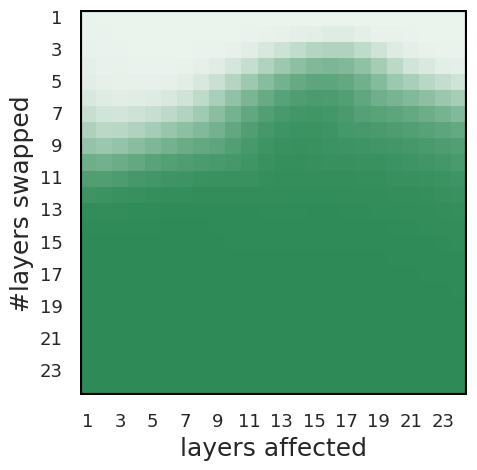

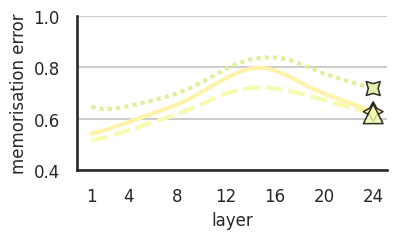

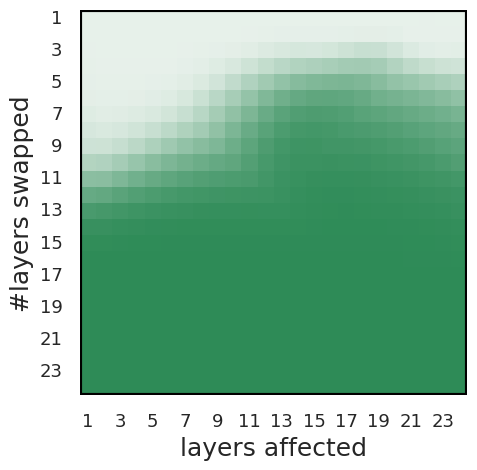

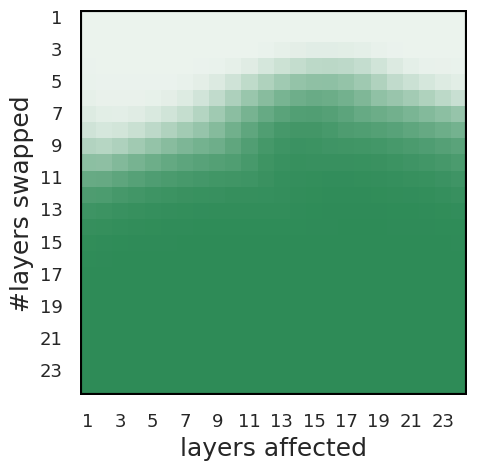

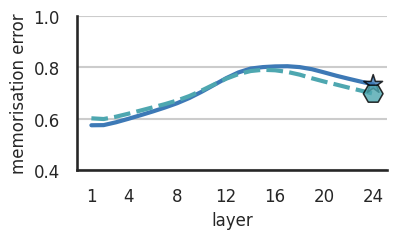

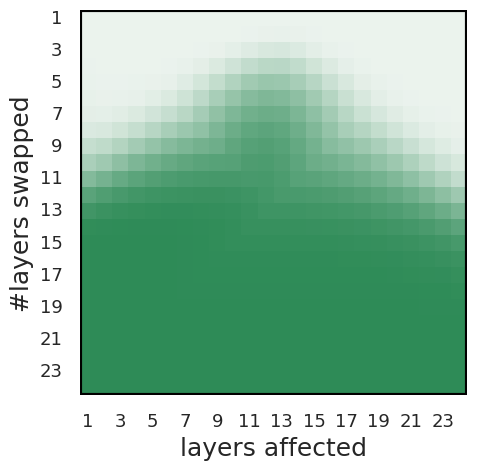

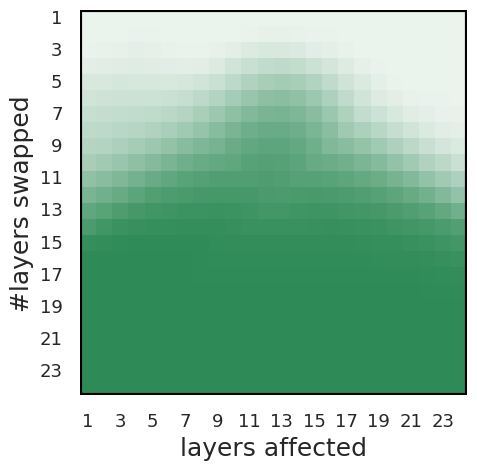

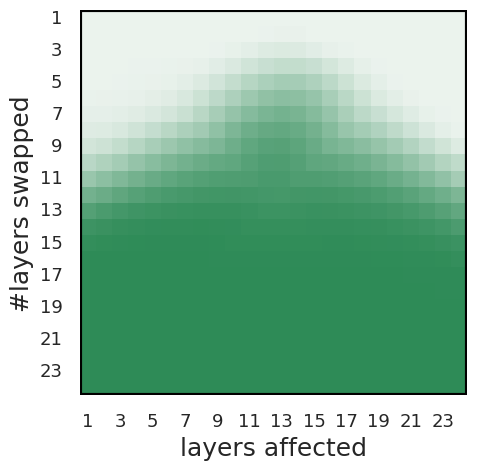

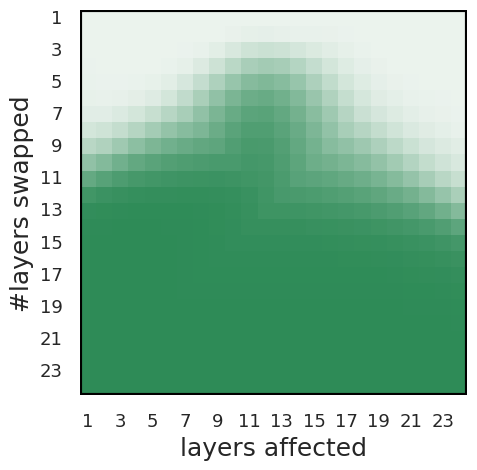

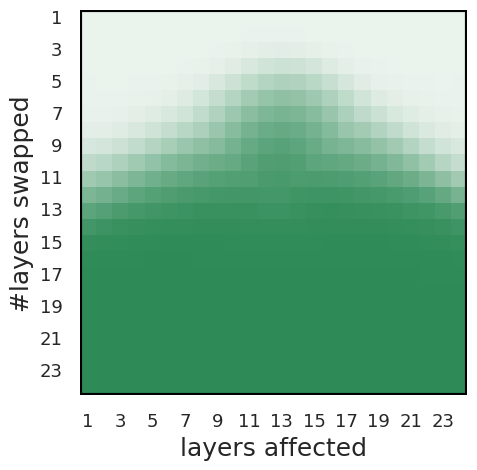

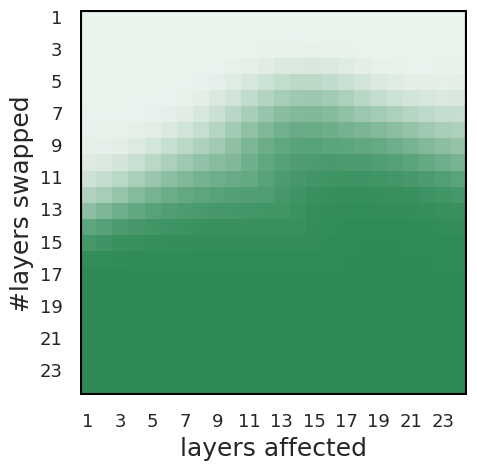

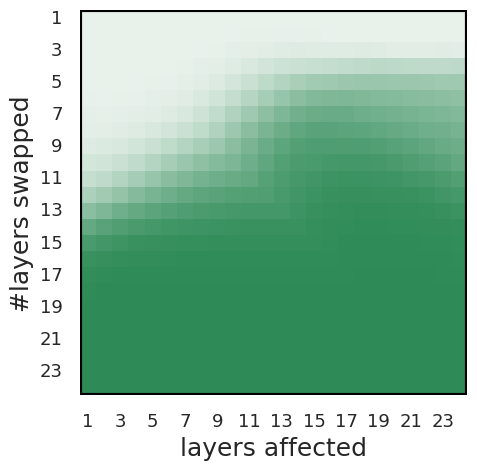

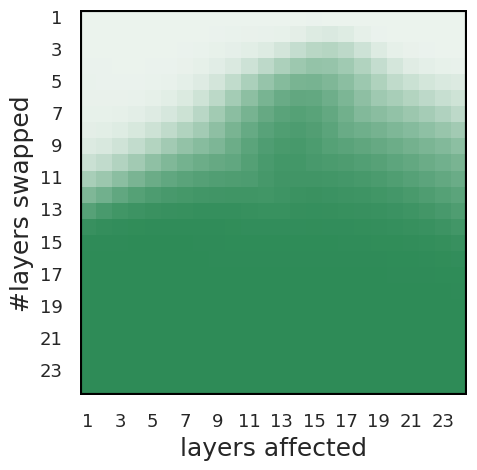

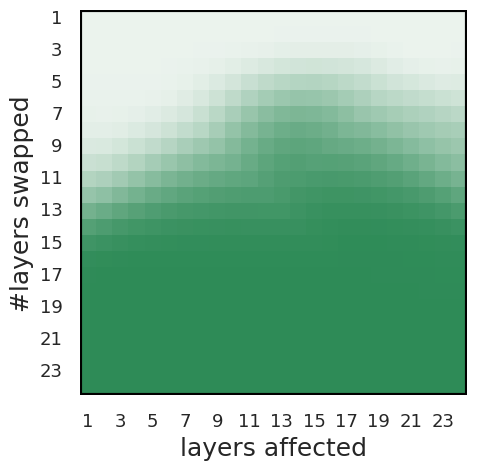

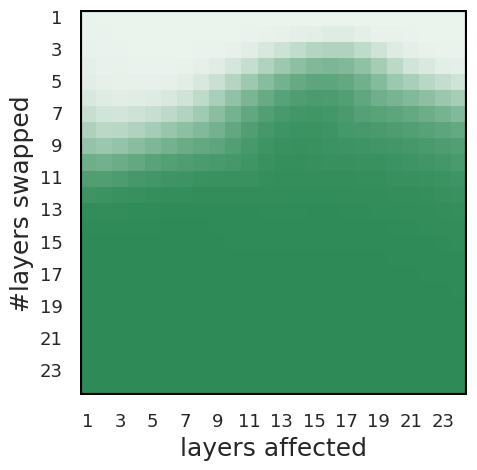

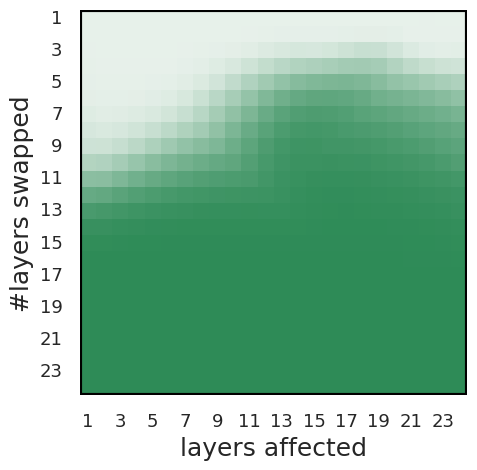

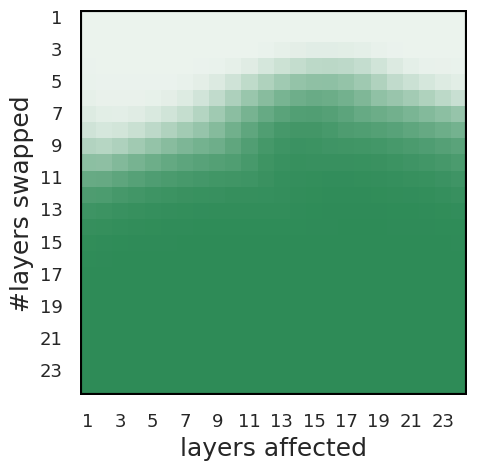

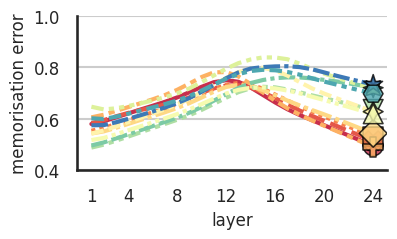

In [22]:
model_setups = [("OPT-1.3B", "facebook_opt-1.3b")]
mcog_big = defaultdict(lambda: dict())

for modeln, model in model_setups:
    for setup, ds_names in utils.data_setups:
        allx, ally, allh = [], [], []
        for dataset in ds_names:
            seed = 1
            filename = f"../results/layer_swapping/{dataset}/{model}_seed={seed}_freeze=embeddings_epoch=50.pt.pickle"
            heatmap, average_over_num_layers_affected, _ = \
                utils.get_heatmap_and_averages(filename, retraining=False, opt_big=True)
            utils.save_heatmap(heatmap, f"layer_swapping/{model}_{dataset}.pdf", numlayers=24)
            allx.extend(list(range(24)))
            ally.extend(heatmap.mean(axis=0))
            allh.extend([dataset]*24)
            norm = np.sum(average_over_num_layers_affected)
            mcog_big[model][dataset] =\
                np.sum([x_*(y_/norm) for x_, y_ in zip(range(0, 24), average_over_num_layers_affected)])

        plt.figure(figsize=(4, 2))
        sns.set_style("white")
        plt.grid(axis='y', zorder=-1)
        ax = sns.lineplot(x=allx, y=ally, hue=allh, palette=utils.palette, style=allh, zorder=1,
                         linewidth=3, errorbar=None, legend=False)

        # Only scatterplot the final x-coordinate
        ax = sns.scatterplot(
            x=[y for y in allx if y == 23],
            y=[y for y, z in zip(ally, allx) if z == 23],
            hue=[y for y, z in zip(allh, allx) if z == 23],
            style=[y for y, z in zip(allh, allx) if z == 23],
            palette=utils.palette,
            markers=utils.marker_dict, edgecolor='black', s=200, alpha=0.8, legend=True)
        plt.legend([],[], frameon=False)
        sns.despine()
        plt.ylabel("memorisation error", fontsize=12)
        plt.xlabel("layer", fontsize=12)
        plt.ylim(0.4, 1)
        locs, labels = plt.yticks()
        ax.set_yticks(locs, labels, fontsize=12)
        ax.set_xticks([0, 3, 7, 11, 15, 19, 23], [1, 4, 8, 12, 16, 20, 24], fontsize=12)
        plt.savefig(f"layer_swapping/{model}_{setup}.pdf", bbox_inches="tight")
        plt.show()
        

In [23]:
for m in mcog:
    for m2 in mcog_big:
        r, p = scipy.stats.spearmanr(
            list(mcog[m].values()),
            list(mcog_big[m2].values()))
        print(f"{m} vs OPT-1.3B: rho = {r:.2f}, p = {p:.2f}")

bert-base-cased vs OPT-1.3B: rho = 0.75, p = 0.01
facebook_opt-125m vs OPT-1.3B: rho = 0.87, p = 0.00
EleutherAI_gpt-neo-125m vs OPT-1.3B: rho = 0.84, p = 0.00
EleutherAI_pythia-160m-deduped vs OPT-1.3B: rho = 0.73, p = 0.01
